In [1]:
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dp = '/home/raiku/.datasets/cifar-10/data_batch_'
train = [unpickle(f'{dp}1'), unpickle(f'{dp}2'), unpickle(f'{dp}3'), unpickle(f'{dp}4'), unpickle(f'{dp}5')]
train_img = np.array([i[b'data'] for i in train]).reshape([-1, 3, 32, 32])
train_labels = np.array([i[b'labels'] for i in train]).reshape([-1])
test = unpickle('/home/raiku/.datasets/cifar-10/test_batch')
meta = unpickle('/home/raiku/.datasets/cifar-10/batches.meta')
label_names = meta[b'label_names']
test_img = np.array(test[b'data']).reshape([-1, 3, 32, 32])
test_labels = np.array(test[b'labels'])

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision as tv
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import adjust_contrast
import torchvision.transforms.v2 as T
from torchvision.io import read_image, ImageReadMode
%matplotlib widget

device = 'cuda'
cudagen = torch.Generator(device=device)
torch.set_default_device(device)
pcount = 8

In [3]:
class ImgDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.augment = augment
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.labels)
        
    def patch(self, image):
        cimg = []
        ch = len(img) // pcount
        cw = len(img[0]) // pcount
        for i in range(pcount):
            for j in range(pcount):
                cimg += [img[i * ch : (i + 1) * ch, j * cw : (j + 1) * cw].reshape([-1, 3])]
        return np.array(cimg).transpose([1, 0])

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        if self.augment:
            image = self.augment(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [4]:
transform = None
augment = None
bsize = 128
trainds = ImgDataset(train_img[0:40000], train_labels[0:40000], transform, augment)
traindl = DataLoader(trainds, batch_size=bsize, shuffle=True, num_workers=0, generator=cudagen)
valds = ImgDataset(train_img[40001:50000], train_labels[40001:50000], transform, None)
valdl = DataLoader(valds, batch_size=bsize, shuffle=False, num_workers=0, generator=cudagen)
testds = ImgDataset(test_img, test_img, transform, None)
testds = DataLoader(testds, batch_size=bsize, shuffle=False, num_workers=0, generator=cudagen)

In [5]:
def getVit():
    from transformers import ViTForImageClassification
    from transformers import ViTImageProcessor
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    model.to(device)
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
    for param in model.parameters():
        param.requires_grad = False
    model = nn.Sequential(*list(model.children())[:-1], nn.Linear(768, 2))
    return model, processor
    
def getDeit():
    from transformers import DeiTForImageClassification
    from transformers import DeiTImageProcessor
    model = DeiTForImageClassification.from_pretrained('facebook/deit-tiny-distilled-patch16-224', attn_implementation='sdpa', torch_dtype=torch.float16, num_labels=10)
    model.to(device)
    processor = DeiTImageProcessor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
    # model = nn.Sequential(*list(model.children())[:-1])
    for param in list(model.parameters())[:-2]:
        param.requires_grad = False
    # for param in model.parameters():
        # print(param.requires_grad)
    # model = nn.Sequential(*list(model.children())[:-1], nn.Linear(192, 10))
    return model, processor

model, processor = getDeit()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
print(sum(p.numel() for p in model.parameters() if not p.requires_grad))
sum(p.numel() for p in model.parameters() if p.requires_grad)

5524800


1930

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


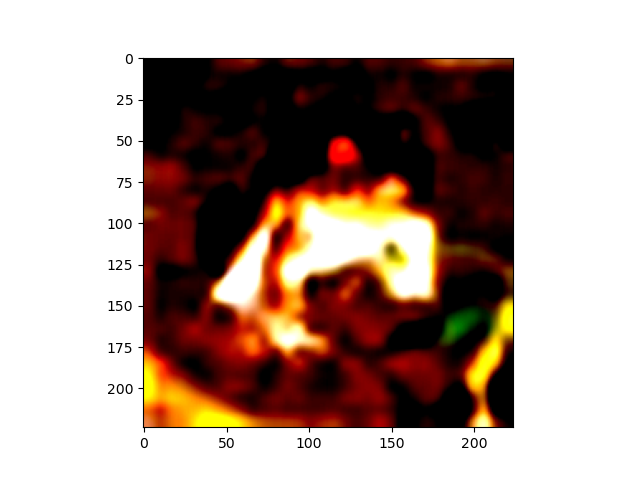

In [7]:
img = processor(images=trainds[0][0], return_tensors='pt').to(device)
ci = img.pixel_values.cpu()[0].numpy().transpose([1, 2, 0])
plt.imshow(ci)
plt.show()

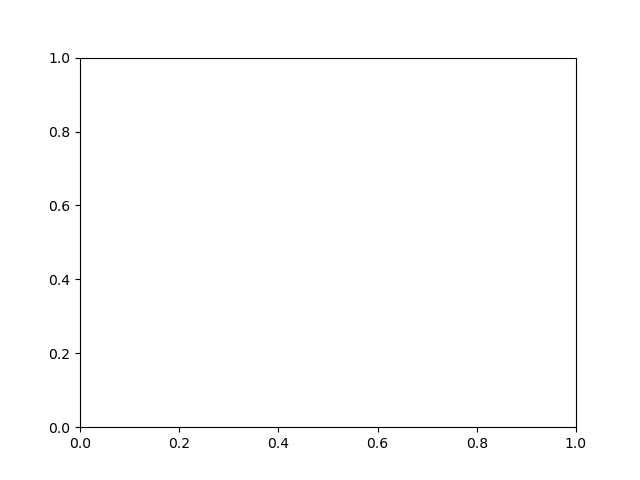

In [11]:
def getstats(outputs, labels):
    res = np.zeros((10, 10), dtype=np.int32)
    c = 0
    for i in range(len(outputs)):
        co = torch.argmax(outputs[i])
        cl = labels[i]
        res[co][cl] += 1
        if co == cl:
            c += 1
    return (res, c)

fig,ax = plt.subplots(1,1)
def updateplt(stats):
    cax = ax.matshow(stats)
    fig.canvas.draw()

In [12]:
def runEpoch(ds, net, optimizer=None, criterion=None):
    stats = np.zeros((10, 10), dtype=np.int32)
    a = iter(ds)
    bar = tqdm(range(len(ds)))
    ct = 0
    sst = 0

    for citer in bar:
        inputs, labels = next(a)
        preprocessed = processor(images=inputs, return_tensors='pt').to(device).pixel_values
        print(preprocessed)
        if optimizer != None:
            optimizer.zero_grad()
        outputs = net(preprocessed).logits
        st = getstats(outputs, labels)
        stats += st[0]
        sst += st[1]
        ct += len(inputs)
        if criterion != None:
            loss = criterion(outputs, labels)
            loss.backward()
        if optimizer != None:
            optimizer.step()
        bar.set_description(f'Training acc: {sst / ct:.2f} {sst} {ct}')
        # print(f'{citer} - ', end='\r')
        updateplt(stats)

In [14]:
from alive_progress import alive_bar
from tqdm.notebook import trange, tqdm

epochs = 10
model, processor = getDeit()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
# torch.manual_seed(42)
# cudagen.manual_seed(42)

for epoch in range(epochs):
    print(f'New epoch: {epoch}')
    runEpoch(traindl, model, optimizer, criterion)
    with torch.no_grad():
        runEpoch(valdl, model, None, None)
    torch.save(model.state_dict(), f"model-{epoch}.pth")

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.